# Reinforcement Learning with Python: Temporal Difference

Let's see how to solve [LunarLander](https://gym.openai.com/envs/LunarLander-v2/) problem with the help of TD agent

![LunarLander](../assets/LunarLander-v2.gif)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
import gym

import matplotlib.pyplot as plt
%matplotlib inline

from pyreinforce.brain import Brain
from pyreinforce.acting import DecayingEpsGreedyPolicy
from pyreinforce.memory import Memory
from pyreinforce import TdAgent

It is as easy as ...

1. ... creating a `Q` network by extending `Brain` class:

In [2]:
class TdBrain(Brain):
    def __init__(self, n_inputs, n_hidden, n_outputs, lr, seed=None):
        super().__init__()

        tf.reset_default_graph()

        # Input layer
        self._X = tf.placeholder(tf.float32, (None, n_inputs))

        # Hidden layer
        W1 = tf.get_variable('W1', shape=(n_inputs, n_hidden), 
                             initializer=tf.glorot_uniform_initializer(seed))
        b1 = tf.get_variable('b1', shape=(n_hidden,), 
                             initializer=tf.zeros_initializer())
        h1 = tf.nn.relu(tf.matmul(self._X, W1) + b1)

        # Output layer
        W2 = tf.get_variable('W2', shape=(n_hidden, n_outputs), 
                             initializer=tf.glorot_uniform_initializer(seed))
        b2 = tf.get_variable('b2', shape=(n_outputs,), 
                             initializer=tf.zeros_initializer())
        self._Q = tf.matmul(h1, W2) + b2

        # Backpropagation
        self._A = tf.placeholder(tf.uint8, (None,))
        A_one_hot = tf.one_hot(self._A, n_outputs)
        Q = tf.reduce_sum(tf.multiply(self._Q, A_one_hot), axis=1)
        self._T = tf.placeholder(tf.float32, (None,))
        loss = tf.reduce_mean(tf.squared_difference(self._T, Q))
        optimizer = tf.train.GradientDescentOptimizer(lr)
        self._train_op = optimizer.minimize(loss)

        self._sess = tf.Session()

    def predict_q(self, states, **kwargs):
        if len(states.shape) < len(self._X.shape):
            states = np.expand_dims(states, axis=0)

        return self._sess.run(self._Q, {self._X: states})

    def train(self, states, actions, targets, **kwargs):
        self._sess.run(self._train_op, {self._X: states, self._A: actions, self._T: targets})

    def __enter__(self):
        self._sess.__enter__()

        init = tf.global_variables_initializer()
        self._sess.run(init)

        return self

    def __exit__(self, *args):
        self._sess.__exit__(*args)

2. ... defining training parameters:

In [3]:
# Seed
seed = 123

# Brain
n_inputs = 8
n_hidden = 128
n_outputs = 4
lr = 0.00025

# Action Selection Policy
start_eps = 1
end_eps = 0
eps_decay = 2

# Replay Memory
replay_memory_size = 1000000
replay_batch_size = 64

# Agent
n_episodes = 5000
gamma = 0.99

3. ... instantiating _environment_, _brain_, _action selection policy_, _replay memory_ and _agent_, and start training by invoking agent's `run()` method:

In [4]:
env = gym.make('LunarLander-v2')
env.seed(seed)

brain = TdBrain(n_inputs, n_hidden, n_outputs, lr, seed)
acting = DecayingEpsGreedyPolicy(start_eps, end_eps, eps_decay)
replay_memory = Memory(replay_memory_size, replay_batch_size)
agent = TdAgent(n_episodes, env, brain, acting, replay_memory, gamma)
agent.seed(seed)

with brain:
    rewards, _ = agent.run()

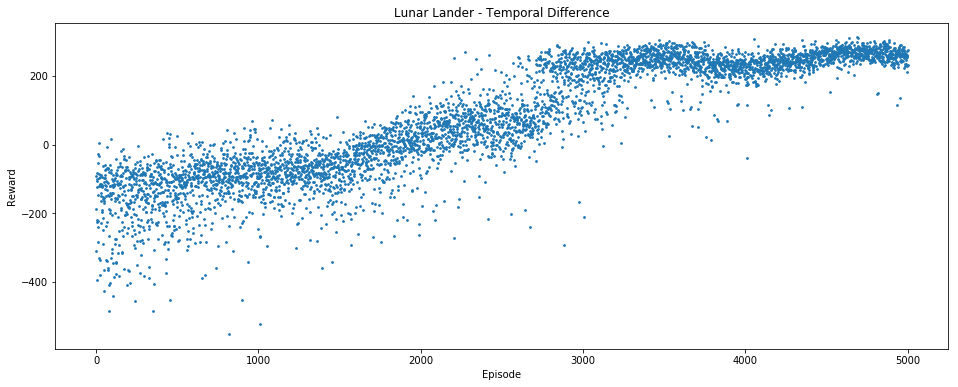

In [5]:
plt.figure(figsize=(16, 6))
plt.title('Lunar Lander - Temporal Difference')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)